_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez

Summer term 2023

Student names: <span style='background: yellow'>Kathrin Root, Alexander Wendt, Patrick Weygoldt</span>

# Coding Lab 1

- __Data__: Download the data file ```nds_cl_1.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.


Recommended folder structure:

```
.
├── data/
│   └── nds_cl_1.csv
├── notebooks
│   └── CodingLab1.ipynb
├── matplotlib_style.txt
└── requirements.txt
```

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import PCA
from __future__ import annotations  # for Python 3.8 and below

# %matplotlib qt

# black is a code formatter (see https://github.com/psf/black).
# It will automatically format the code you write in the cells imposing consistent Python style.
%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-04-25 20:52:46CEST

Python implementation: CPython
Python version       : 3.11.2
IPython version      : 8.12.0

sklearn: 1.2.2

numpy     : 1.24.2
matplotlib: 3.7.1
pandas    : 2.0.0
scipy     : 1.10.1

Watermark: 2.3.1



In [ ]:
# matplotlib style file
# Template for style file: https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
plt.style.use("../matplotlib_style.txt")

# from plotstyle import PlotStyle
# ps = PlotStyle()

## Load data

In [ ]:
fs = 30000.0  # sampling rate of the signal in Hz
dt = 1 / fs
cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
x = pd.read_csv("../data/nds_cl_1.csv", header=0, names=cols)

In [ ]:
x.describe()

,Ch1,Ch2,Ch3,Ch4
count,1.920000e+07,1.920000e+07,1.920000e+07,1.920000e+07
mean,3.600331e+00,-8.850918e-01,2.864284e-01,2.210982e+00
std,5.824474e+02,6.014818e+02,6.464363e+02,6.126105e+02
min,-3.607000e+03,-3.739000e+03,-3.871000e+03,-3.750000e+03
25%,-3.460000e+02,-3.610000e+02,-3.950000e+02,-3.640000e+02
50%,1.200000e+01,8.000000e+00,-1.000000e+00,1.000000e+01
75%,3.650000e+02,3.720000e+02,4.010000e+02,3.810000e+02
max,2.873000e+03,3.004000e+03,3.099000e+03,3.017000e+03


## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filter_signal()```. A typical choice for this task would be a <mark>butterworth filter</mark>. Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings.

*Grading: 2 pts*


For our filter we chose the butterworth bandpass filter. This takes care of removing the high- and low frequency noise in a single operation.

In [ ]:
def filter_signal(
    x: pd.DataFrame, fs: float, low: float, high: float, order: int = 3
) -> pd.DataFrame:
    """Filter raw signal x.

    Parameters
    ----------

    x: pd.DataFrame, (n_samples, n_channels)
        Each column in x is one recording channel.

    fs: float
        Sampling frequency.

    low, high: float, float
        Passband in Hz for the butterworth filter.

    order: int
        The order of the Butterworth filter. Default is 3, but you should try
        changing this and see how it affects the results.


    Returns
    -------

    y: pd.DataFrame, (n_samples, n_channels)
        The filtered x. The filter delay is compensated in the output y.


    Notes
    ----

    1. Try exploring different filters and filter settings. More info:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

    2. The output signal should be phase-shift compensated. More info:
    https://dsp.stackexchange.com/a/19086

    """
    # create empty list to store the filtered signal
    signals = []
    col_names = []
    for col in x.columns:
        # get the data from one channel
        data = x[col].values

        # get the filter coefficients
        coeffs = signal.butter(order, [low, high], "band", fs=fs, output="sos")

        # pass the filter coefficients and the data to the filter function
        filtered_data = signal.sosfiltfilt(sos=coeffs, x=data)

        # append to empty list
        signals.append(filtered_data)
        col_names.append(col)

    # convert list to pd.DataFrame
    df = pd.DataFrame(np.asarray(signals).T, columns=col_names)

    return df

Here we apply the filter and create a time axis for plotting the signal using its samplingrate.

In [ ]:
xf = filter_signal(x, fs, 500, 5000)
time = np.arange(0, len(xf) / fs, dt)

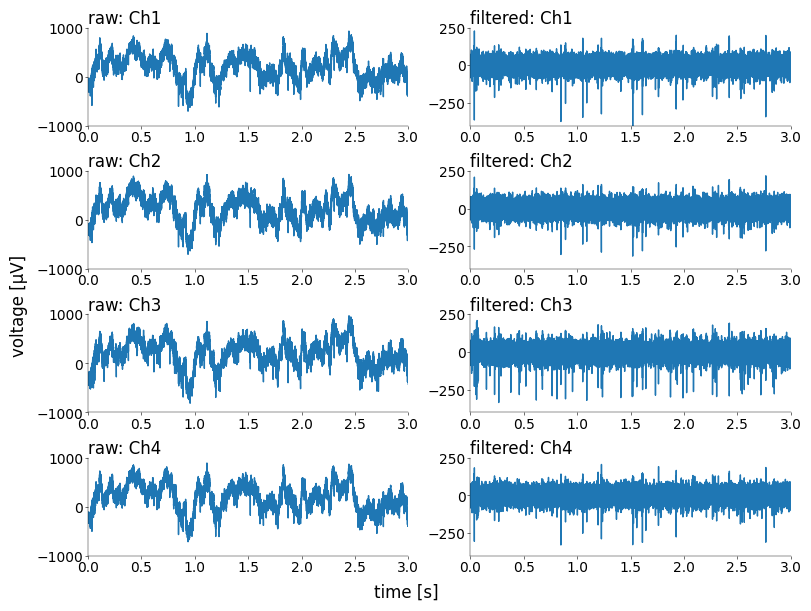

In [ ]:
mosaic = [
    ["raw: Ch1", "filtered: Ch1"],
    ["raw: Ch2", "filtered: Ch2"],
    ["raw: Ch3", "filtered: Ch3"],
    ["raw: Ch4", "filtered: Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

for i, m in enumerate(mosaic):
    raw = m[0]
    filtered = m[1]

    sig = x[raw[-3:]].values
    sigf = xf[raw[-3:]].values

    ax[raw].plot(time, sig, lw=1)
    ax[filtered].plot(time, sigf, lw=1)

    ax[raw].set_xlim((0, 3))
    ax[raw].set_ylim((-1000, 1000))

    ax[filtered].set_xlim((0, 3))
    ax[filtered].set_ylim((-400, 250))

    fig.supylabel("voltage [\u03BCV]", fontsize=12)
    fig.supxlabel("time [s]", fontsize=12)
    ax[filtered].set_title(m[1], loc="left")

    ax[raw].set_title(m[0], loc="left")

## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detect_spikes()``` . Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes. **Plot the threshold**. Are the detected time points well aligned with peaks in the signal?

*Grading: 3 pts*

For this we first need to convert the pandas dataframe into a np.ndarray.

In [ ]:
xf = xf.values
print(xf.shape)

(19199999, 4)


In the following we will detect peaks on all electrodes seperately and group closeby indices afterwards. The threshold is same over all four channels. 
Spikes detected on one channel are labeled as spikes at the same time (+/- 3 samples) on all the other channels even if the amplitude at the time of the spike on the other channels is too small to cross the threshold.


In [ ]:
def detect_spikes(
    x: np.ndarray, fs: float, N: int = 5, lockout: int = 10
) -> tuple[np.ndarray, np.ndarray, np.float64]:
    """Detect spikes, in this case, the relative local minima of the signal x.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal from Task 1.

    fs: float
        the sampling rate (in Hz).

    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.

    lockout: int
        a window of 'refactory period', within which there's only one spike.
        Default is 10 but you should also try changing it.


    Returns
    -------

    s: np.array, (n_spikes, )
        Spike location / index in the singal x.

    t: np.array, (n_spikes, )
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.

    thrd: float
        Threshold = -N * sigma.


    Tips
    ----

    Use scipy functions to detect local minima.
    Noted that there are four channels in signal x.

    """
    spike_indices = []
    thresh = np.median(np.abs(x - np.median(x)) / 0.6745) * N

    # detect peaks for each channel
    for ch in range(x.shape[1]):
        sig = -x[:, ch]
        sig[sig < thresh] = 0
        spikes, _ = signal.find_peaks(sig, distance=lockout)
        spike_indices.extend(spikes.tolist())

    # remove all redundant duplicates
    spike_indices = np.unique(np.sort(np.asarray(spike_indices)))

    # group all close spike indices
    tolerance = 3
    spike_indices = np.split(
        spike_indices, np.where(np.diff(spike_indices) > tolerance)[0] + 1
    )

    # compute the rounded mean of each group and use it as the spike index
    spike_indices = np.asarray([int(np.round(np.mean(s))) for s in spike_indices])
    spike_times = spike_indices / fs

    return spike_indices, spike_times, -thresh

In [ ]:
s, t, thrd = detect_spikes(xf, fs, N=4)
print(f"Number of spikes: {len(s)}")
print(f"Threshold: {thrd}")

Number of spikes: 35694
Threshold: -144.16209293776012


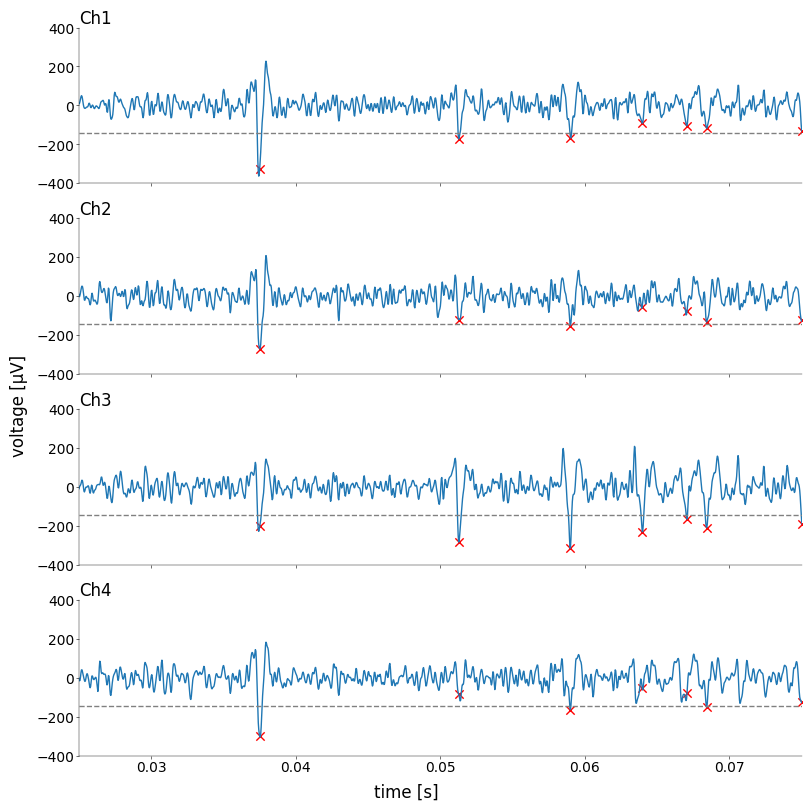

In [ ]:
mosaic = [
    ["Ch1"],
    ["Ch2"],
    ["Ch3"],
    ["Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100, sharex=True
)

for i, col in enumerate(cols):
    x = xf[:, i]
    ax[col].plot(time, x, lw=1)
    ax[col].scatter(t, x[s], marker="x", color="red")
    ax[col].axhline(thrd, color="gray", ls="--", lw=1)

    ax[col].set_ylim((-400, 400))
    ax[col].set_xlim((0.025, 0.075))
    ax[col].set_title(col, loc="left")

    fig.supxlabel("time [s]", fontsize=12)
    fig.supylabel("voltage [\u03BCV]", fontsize=12)
    fig.align_labels()

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extract_waveforms()```. Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected. Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

*Grading: 2 pts*

In [ ]:
def extract_waveforms(x: np.ndarray, s: np.ndarray) -> np.ndarray:
    """Extract spike waveforms at times s (given in samples)
    from the filtered signal `xf` using a fixed window around the
    times othrdf the spikes.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal.

    s: np.array, (n_spikes, n_channels)
        Spike time in samples.


    Return
    ------

    w: np.array, (n_spikes, length_window, n_channels)
        Waveforms. (You don't have to get the exact same
        shape as we noted here. It's just the shape of w
        that can be easily retrieved via broadcasting.)


    Notes
    -----

    More on Numpy Broadcasting
    https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html

    """
    # create a window of 10 samples before and 20 after the spike
    # window_index = np.arange(-10, 20)

    # Array broadcasting: Add window to indices. We need to add a new axis
    # because the window_index is 1D and the spike indices are 2D.
    # the np.newaxis just makes the window_index 2D.
    # window_indices = s[:, np.newaxis] + window_index

    # Now we can use the window_indices to extract the waveforms from the signal.
    # output = x[window_indices]

    # this can all be put in one line:
    return x[s[:, np.newaxis] + np.arange(-10, 20)]


w = extract_waveforms(xf, s)
print(np.shape(w))

(35694, 30, 4)


Text(0.02, 0.5, 'voltage [μV]')

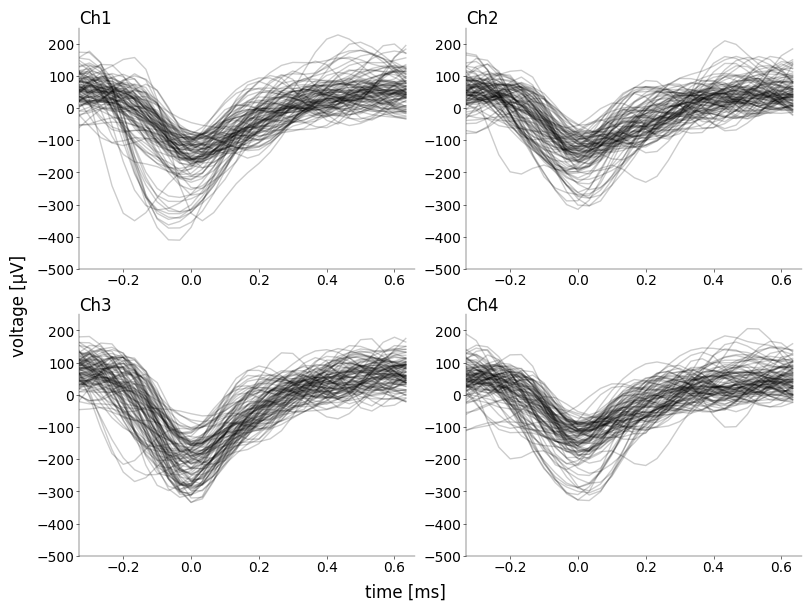

In [ ]:
mosaic = [
    ["Ch1", "Ch2"],
    ["Ch3", "Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

time = np.arange(-10, 20) / fs * 1000

# cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
for i, col in enumerate(cols):
    ax[col].plot(time, w[:100, :, i].T, color="black", lw=1, alpha=0.2)
    ax[col].set_ylim((-500, 250))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")

fig.supxlabel("time [ms]", fontsize=12)
fig.supylabel("voltage [\u03BCV]", fontsize=12)

Plot largest 100 spike waveforms

To get the largest 100 waveforms, we can use `numpy.argsort` if we can extract the maxima. The following command will take all values of the second and third axis (i.e. all samples and all channels) of the extracted waveforms in $w$ and return the largest value for each waveform.

In [ ]:
maxima = np.min(w, axis=(1, 2))
print(maxima[:100])

[-363.14603726 -281.92681059 -313.29734102 -228.70845381 -164.00587698
 -207.65115283 -189.26935792 -246.5894946  -157.19536367 -281.47667102
 -334.47064061 -158.99790895 -267.1223504  -282.16032643 -204.1581294
 -226.19268583 -318.38002623 -246.84100521 -289.69337732 -153.13391989
 -310.93376582 -372.97404989 -193.99928428 -310.33312055 -262.06724904
 -345.89762105 -320.50760207 -235.57695096 -322.59926443 -297.3801607
 -147.53239784 -158.32863104 -301.98199701 -150.56538866 -295.22045305
 -410.49185377 -193.87950531 -148.50746901 -230.47726903 -152.19128323
 -328.19994114 -248.83035737 -248.83035737 -242.35482006 -286.14317662
 -211.13900525 -152.75089431 -145.89161443 -297.98058979 -146.02818165
 -290.39145143 -213.45875482 -304.11103456 -189.51399458 -269.34747485
 -269.34747485 -154.37510925 -262.27338453 -158.20704498 -281.91616178
 -174.00370635 -155.57133186 -199.61955389 -295.13212988 -167.99190233
 -290.66815646 -192.84089175 -252.43323234 -157.9949674  -276.87739447
 -248.92

Now we can easily get the indices of the largest waveforms `numpy.argsort`, which returns the indices that would sort the array.

In [ ]:
sorted_indices = np.argsort(maxima)

Now we just need to index the waveforms using the `sorted_indices` to get the largest waveforms and plot them in the same way as before. The whole procedure can also be done in a single line:

In [ ]:
sorted_waveforms = w[np.argsort(np.min(w, axis=(1, 2))), :, :]

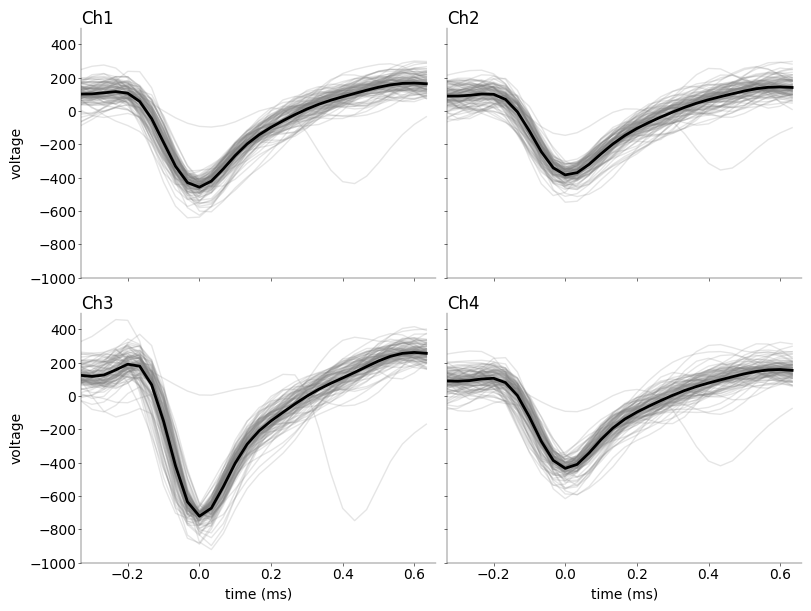

In [ ]:
mosaic = [
    ["Ch1", "Ch2"],
    ["Ch3", "Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# also add the mean
means = np.mean(sorted_waveforms[:100, :, :], axis=0)

for i, col in enumerate(cols):
    ax[col].plot(time, sorted_waveforms[:100, :, i].T, color="gray", lw=1, alpha=0.2)
    ax[col].plot(time, means[:, i].T, color="black", lw=2, alpha=1)
    ax[col].set_ylim((-1000, 500))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage")
    else:
        ax[col].set_yticklabels([])

## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extract_features()``` (2 pts). You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs.
Plot scatter plots for all pairwise combinations of 1st PCs. Do you see clusters visually? 

*Grading: 2+1 pts*


### PCA:
- how to preprocess data?


(https://stats.stackexchange.com/questions/385775/normalizing-vs-scaling-before-pca)

In [ ]:
from sklearn.preprocessing import scale, normalize, StandardScaler


def extract_features(w: np.ndarray):
    """Extract features for spike sorting from the waveforms w.

    Do PCA on the waveforms of each channel separately,
    then concatenate the first three principal components
    of each channels into one numpy array (`b`).


    Parameter
    ---------

    w: np.ndarray, (n_spikes, length_window, n_channels)
        Waveforms from Task 3.


    Return
    ------

    b: np.ndarray, (n_spikes, n_feature)


    Notes
    -----

    You can use PCA from sklearn.

    More on PCA
    https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

    """
    # use the PCA class from sklearn and reduce the matrix to 3 dimensions
    pca = PCA(n_components=3)
    # calculate the PCA for every channel
    for i in range(w.shape[2]):
        input = w[:, :, i]
        output = pca.fit_transform(input)
        # combine the output to one array
        if i == 0:
            b = output
        else:
            b = np.concatenate((b, output), axis=1)
        # print the explained variance
        print(
            f"Explained variance ratio for channel {i+1}: {pca.explained_variance_ratio_}"
        )

    return b

In [ ]:
b = extract_features(w)
print(b.shape)

Explained variance ratio for channel 1: [0.49543188 0.22374809 0.07320718]
Explained variance ratio for channel 2: [0.40652697 0.22460507 0.09447735]
Explained variance ratio for channel 3: [0.43913007 0.23038406 0.09023702]
Explained variance ratio for channel 4: [0.42429928 0.22073761 0.09471362]
(35694, 12)


Text(0.5, 0.98, 'Pairwise 1st PCs')

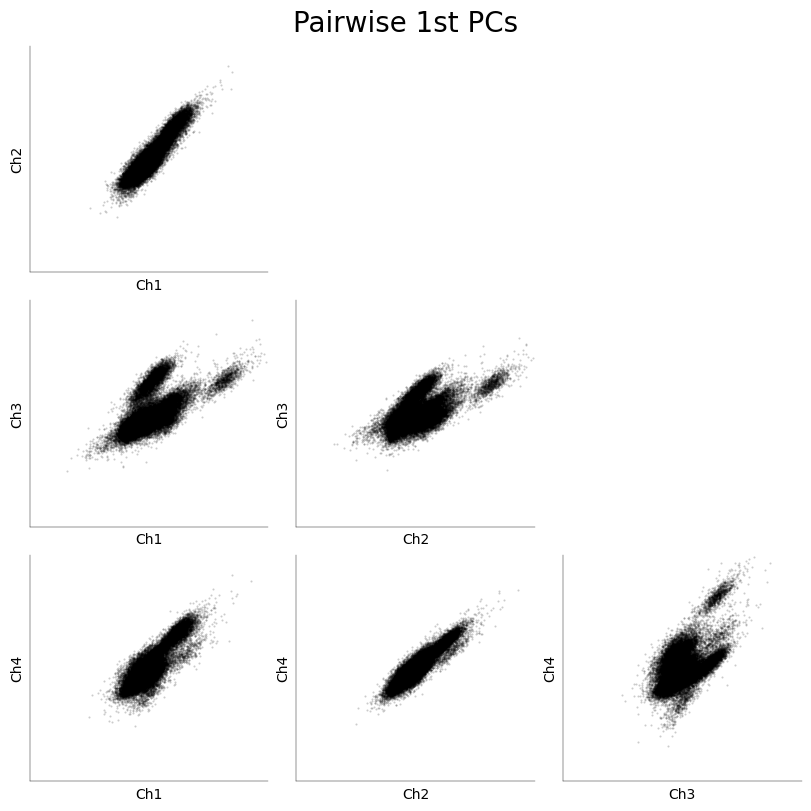

In [ ]:
mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# indices of the 1st PC in `b`
i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}

for m in np.ravel(mosaic):
    if m == ".":
        continue
    # get the indices of the channel for the first channel vs second channel
    firstch = i[m[:3]]
    secondch = i[m[-3:]]
    ax[m].scatter(b[:, firstch], b[:, secondch], s=1, color="black", alpha=0.2)

    y, x = m.split(" vs ")

    ax[m].set_xlabel(x)
    ax[m].set_ylabel(y)
    ax[m].set_xlim((-1500, 1500))
    ax[m].set_ylim((-1500, 1500))
    ax[m].set_xticks([])
    ax[m].set_yticks([])

fig.suptitle("Pairwise 1st PCs", fontsize=20)

In [ ]:
# # save data for the next Coding Lab

np.save("../data/nds_cl_1_features", b)
np.save("../data/nds_cl_1_spiketimes_s", s)
np.save("../data/nds_cl_1_spiketimes_t", t)
np.save("../data/nds_cl_1_waveforms", w)

We can estimate 3 clusters between the first PC in channel 1 vs 3 and channel 2 vs 3. And 2 cluster in channel 3 vs 4. 